##### 【 KNN기반 Bream_Smelt 식별 모델 】
- 데이터 : 1000개  bream_smelt_best.csv
- 데이터셋
    * 피쳐 : Weight, Length
    * 타겟 : Species
- 학습종류
    * 지도학습 => 분류 : 2진분류
    * 알고리즘 => 최근접이웃 알고리즘 : 거리기반=>스케일링필수. 메모리 고려.

[1] 모듈 로딩 및 데이터 준비<hr>

In [15]:
## 로딩.분석.전처리 모듈 
import numpy as np
import pandas as pd 

## 시각화 모듈
import matplotlib.pyplot as plt
import koreanize_matplotlib 

## ML 모델 / 전처리 모듈
from sklearn.preprocessing import StandardScaler, RobustScaler  # 전처리
from sklearn.model_selection import train_test_split            # 데이터셋 분리
from sklearn.neighbors import KNeighborsClassifier              # 알고리즘 


In [16]:
## 데이터 로딩
DATA_FILE = '../Data/bream_smelt.csv'

## CSV => DataFrame 로딩
fishDF = pd.read_csv(DATA_FILE)

[2] 데이터 확인 및 전처리<hr>

In [28]:
## [2-1] 데이터 확인 :  info()/describe()/.... 
display( fishDF.head(3) )
fishDF.info()

,Species,Weight,Length
0,Bream,323.587836,28.928442
1,Bream,402.087382,32.901921
2,Bream,313.261134,26.439356


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Species  1000 non-null   category
 1   Weight   1000 non-null   float64 
 2   Length   1000 non-null   float64 
dtypes: category(1), float64(2)
memory usage: 16.9 KB
Index(['Weight', 'Length'], dtype='object')


In [18]:
## -----------------------------------------
## 컬럼별 기술통계 확인 
## -----------------------------------------
## => Weiht, Lenght 모두 음의 왜도. 왼쪽꼬리, 오른쪽 쏠림
fishDF.describe()

,Weight,Length
count,1000.000000,1000.000000
mean,442.173820,28.804592
std,133.075903,2.662829
min,31.946399,20.836311
25%,348.529298,27.031225
50%,455.379492,29.047167
75%,540.597538,30.555417
max,777.715958,35.606743


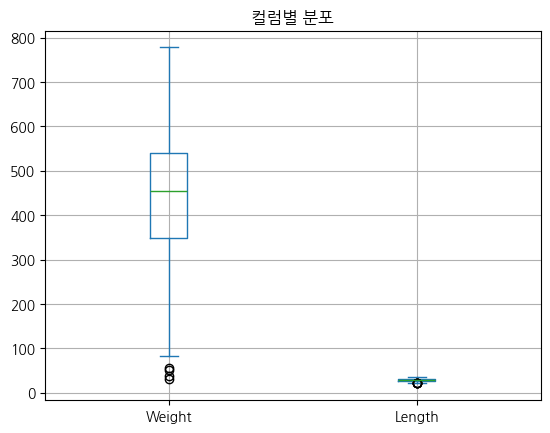

In [19]:
## -----------------------------------------
## 결측치/중복값/이상치
## -----------------------------------------
fishDF.isna().sum()         ## => 0개

fishDF.duplicated().sum()   ## => 0개

fishDF.plot(kind='box', title='컬럼별 분포', grid=True)
plt.show()

In [20]:
## [2-2] 데이터 타입 :  품종 컬럼 object => category
pd.options.mode.copy_on_write = True

fishDF.Species = fishDF.Species.astype('category')
fishDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Species  1000 non-null   category
 1   Weight   1000 non-null   float64 
 2   Length   1000 non-null   float64 
dtypes: category(1), float64(2)
memory usage: 16.9 KB


[3] 학습관련 전처리 및 준비 <hr>
- 피쳐와 타겟 분리
- 학습용과 테스트용 데이터셋 분리
- 1개의 Data 파일경우 학습용 스케일렁 생성 및 학습용/테스트용 적용 

In [21]:
## [3-1] 피쳐와 타겟 분리
featureDF = fishDF[fishDF.columns[1:]]
targetSR  = fishDF[fishDF.columns[0]]

print(f'featureDF => {featureDF.shape} / {featureDF.ndim}D')
print(f'targetSR  => {targetSR.shape} / {targetSR.ndim}D')

featureDF => (1000, 2) / 2D
targetSR  => (1000,) / 1D


In [22]:
## [3-2] 학습용과 테스트용 데이터셋 분리 [기: 57:25]
x_train , x_test, y_train, y_test = train_test_split(featureDF,
                                                     targetSR,
                                                     test_size=0.2,
                                                     random_state=7,
                                                     stratify=targetSR)


In [23]:
## 학습용, 테스트용 데이터 개수
print(f'[학습용]   {x_train.shape} {x_train.ndim}D,  {y_train.shape} {y_train.ndim}D')
print(f'[테스트용] {x_test.shape} {x_test.ndim}D,  {y_test.shape} {y_test.ndim}D')

## 2개 라벨/클래스 Bream, Smelt 비율 
targetL = (targetSR.value_counts()/targetSR.shape[0]).to_list()
trainL  = (y_train.value_counts()/y_train.shape[0]).to_list()
testL   = (y_test.value_counts()/y_test.shape[0]).to_list()

print(f'[Target] Bream : Smelt = {targetL[0]:.1f} : {targetL[1]:.1f}')
print(f'[Train]  Bream : Smelt = {trainL[0]:.1f} : {trainL[1]:.1f}')
print(f'[Test]   Bream : Smelt = {testL[0]:.1f} : {testL[1]:.1f}')

[학습용]   (800, 2) 2D,  (800,) 1D
[테스트용] (200, 2) 2D,  (200,) 1D
[Target] Bream : Smelt = 0.7 : 0.3
[Train]  Bream : Smelt = 0.7 : 0.3
[Test]   Bream : Smelt = 0.7 : 0.3


In [24]:
## [3-3] 수치형 피쳐들 스케일 조정 : 스케일러 생성 ★학습용 데이터셋으로 생성
##=> 학습용 데이터셋 기반 스케일러 생성
stdScaler = StandardScaler()
stdScaler.fit(x_train)
print("모델파라미터 :", stdScaler.mean_ , stdScaler.var_, stdScaler.scale_)

##=> 학습용/테스트용 데이터셋 스케일링 진행 => ★ndarray 타입 
s_x_train = stdScaler.transform(x_train)
s_x_test  = stdScaler.transform(x_test)

모델파라미터 : [444.05607782  28.80071839] [1.74337575e+04 7.12021348e+00] [132.03695488   2.66837281]


[4] 학습 진행 => 기준성능 설정 : 학습 모델 기본값 그대로 학습 <hr>

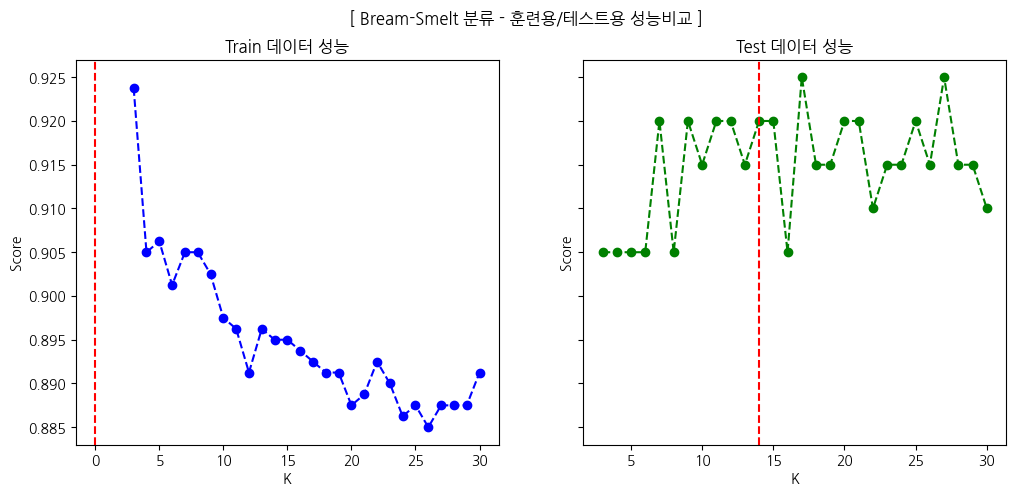

In [25]:
## -------------------------------------------
## [4-0] 최적의 K값 찾기 
## -------------------------------------------
## 훈련용/테스트용 성능 저장
scoreDict = {'Train':[], 'Test':[]}

## 최근접 이웃수 n_neighbors 범위 : 1 ≤ ~ ≤ √데이터수
MAX_K = 31

## 최적 성능의 k 즉, n_neighbors 찾기
for k  in range(3, MAX_K):
    ##- 모델 인스턴스 생성
    kModel = KNeighborsClassifier(n_neighbors=k) 
   
    ##- 모델 학습 : 학습용 데이터셋
    kModel.fit(s_x_train, y_train)

    ##- 모델 성능평가 : 테스트용 데이터셋
    train_score = kModel.score(s_x_train, y_train)
    test_score  = kModel.score(s_x_test, y_test)

    ##- 학습과 테스트 성능비교 위한 저장 
    scoreDict['Train'].append(train_score)
    scoreDict['Test'].append(test_score)

##- k 개수에 다른 학습 및 테스트 성능 시각화 
nrow, ncol = 1, 2

fig, axes = plt.subplots(nrow, ncol, sharey=True, figsize=(12, 5))

for idx, target, fmt in zip(range(nrow*ncol), ['Train', 'Test'] , ['bo--', 'go--']):
    best_ = np.array(scoreDict[target]).argmax()
    axes[idx].plot(range(3, MAX_K), scoreDict[target], fmt)
    axes[idx].set_xlabel('K')
    axes[idx].set_ylabel('Score')
    axes[idx].set_title(f"{target} 데이터 성능")
    axes[idx].axvline(best_, ymin=0, ymax=1, color='red', linestyle='dashed')

plt.suptitle('[ Bream-Smelt 분류 - 훈련용/테스트용 성능비교 ]')
plt.show()

In [26]:
scores = pd.DataFrame(scoreDict)
scores['diff'] = (scores['Train'] - scores['Test']).abs()
scores.sort_values(by='diff').head()

,Train,Test,diff
1,0.90500,0.905,0.00000
5,0.90500,0.905,0.00000
2,0.90625,0.905,0.00125
3,0.90125,0.905,0.00375
13,0.89375,0.905,0.01125


In [27]:
## [4-1] 모델 인스턴스 생성
kModel = KNeighborsClassifier(n_neighbors=BEST_K)
kModel

NameError: name 'BEST_K' is not defined

In [ ]:
## [4-2] 학습 진행 => 학습용 데이터셋만 사용
## .fit(2D_피쳐, 1D_타겟)
kModel.fit(s_x_train, y_train)

InvalidParameterError: The 'n_neighbors' parameter of KNeighborsClassifier must be an int in the range [1, inf) or None. Got 0 instead.

[5] 성능평가 : 테스트용 데이터셋 진행<hr>
- 학습용, 테스트용 성능 비교

In [ ]:
## .score(2D_피쳐, 1D_타겟)
train_score = kModel.score(s_x_train, y_train)
test_score  = kModel.score(s_x_test, y_test)

print(f'[성능비교]\n*학습 점수 : {train_score}   *테스트 점수 : {test_score}')

[성능비교]
*학습 점수 : 1.0   *테스트 점수 : 1.0


[6] 일반적인 데이터 예측 서비스<hr>
- ★★★ 반드시 데이터는 스케일링 후 진행

In [ ]:
## 아무 도미 또는 빙어의 길이/무게 ==> 도미와 빙어 예측
in_data = input("생선의 무게, 길이 입력(예:120 23):").strip().split()
in_data  = list(map(float, in_data))
print(f'new_data : {in_data}', end=' ')

## DF 형식으로 저장
new_data = pd.DataFrame([in_data] , columns=fishDF.columns[1:])

## 스케링일 진행
s_new_data = stdScaler.transform(new_data)
print(f'=> s_new_data : {s_new_data}' )

NameError: name 'fishDF' is not defined

In [ ]:
## 예측 진행
pre_target = kModel.predict(s_new_data)

print(f'무게 {in_data[0]}g, 길이 {in_data[1]}mm 생선은 {pre_target.item()}입니다.')

무게 178.0g, 길이 29.0mm 생선은 Bream입니다.


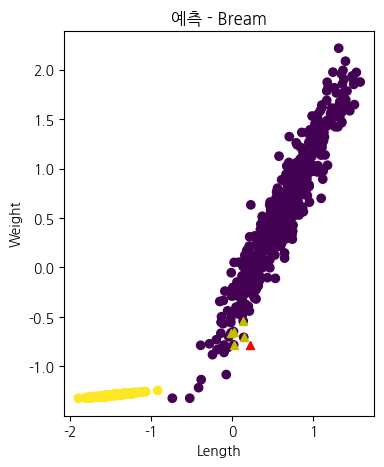

In [ ]:
## 예측 검사
_, sIndices = kModel.kneighbors(s_new_data)

## 시각화 
plt.figure(figsize=(4, 5))
plt.scatter(s_x_train[:, 1], s_x_train[:, 0], c=y_train.cat.codes)

#-> 새로운 데이터
plt.plot(s_new_data[0][1], s_new_data[0][0], '^r')

# #-> 이웃 데이터
nIdx = sIndices[0].tolist()
for idx in nIdx:
    plt.plot(s_x_train[idx][1], s_x_train[idx][0], '^y')

plt.xlabel('Length')
plt.ylabel('Weight')
plt.title(f'예측 - {pre_target.item()}')
plt.show()